# Autoencoders in fastai

This is the corresponding notebook for my blog post on creating autoencoders in fastai.

## Import Required Libraries

In [1]:
from fastai import *
from fastai.vision import *
import torch
from torch import nn
import torch.nn.functional as F

## Import Data

In [2]:
np.random.seed(3333)
torch.manual_seed(3333)

image_path = os.getcwd() + "/data/"
size = 32
batchsize = 32
tfms = get_transforms(do_flip = True)
src = (ImageImageList.from_folder(image_path).use_partial_data(0.1)
       .split_by_rand_pct(seed=2).label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))

In [3]:
data

ImageDataBunch;

Train: LabelList (4800 items)
x: ImageImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: /Users/henriwoodcock/Documents/Code/github Page/Post_Codes/autoencoders-in-fastai/data;

Valid: LabelList (1200 items)
x: ImageImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: /Users/henriwoodcock/Documents/Code/github Page/Post_Codes/autoencoders-in-fastai/data;

Test: None

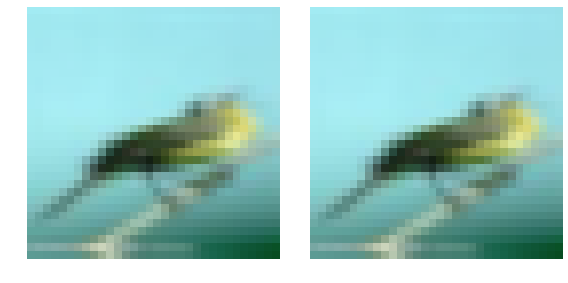

In [4]:
data.show_batch(rows = 1)

### Array Data
If using an array dataset you can use the below code:

In [4]:
class ArrayDataset(Dataset):
    "Sample numpy array dataset"
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.c = 2 # binary label
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [5]:
train_data = np.random.rand(50,5)
valid_data = np.random.rand(5, 5)
train_ds = ArrayDataset(train_data, train_data)
valid_ds = ArrayDataset(valid_data, valid_data)

In [6]:
array_data = DataBunch.create(train_ds, valid_ds, bs=32)
array_data

DataBunch;

Train: <__main__.ArrayDataset object at 0x12d8c1f98>;

Valid: <__main__.ArrayDataset object at 0x12c935630>;

Test: None

## Model
Here I have included the model I used for the image dataset, however you can create your own custom model. If you are using an array dataset you will need to.

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )
        
    def encode(self, x): return self.encoder(x)
    
    def decode(self, x): return self.decoder(x)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Learner

In [8]:
autoencoder = Autoencoder()

In [9]:
learn = Learner(data, autoencoder, loss_func = F.mse_loss)

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-03
Min loss divided by 10: 1.45E-02


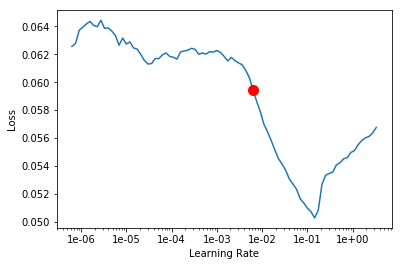

In [11]:
learn.recorder.plot(suggestion = True)

In [12]:
learn.fit_one_cycle(10, max_lr = 1e-02)

epoch,train_loss,valid_loss,time
0,0.021670,0.016256,00:11
1,0.009263,0.008958,00:10
2,0.006565,0.007575,00:11
3,0.004957,0.007281,00:11
4,0.004542,0.004986,00:11
5,0.003198,0.004294,00:12
6,0.002636,0.003688,00:11
7,0.002252,0.003396,00:11
8,0.002035,0.003269,00:11
9,0.001985,0.003231,00:10


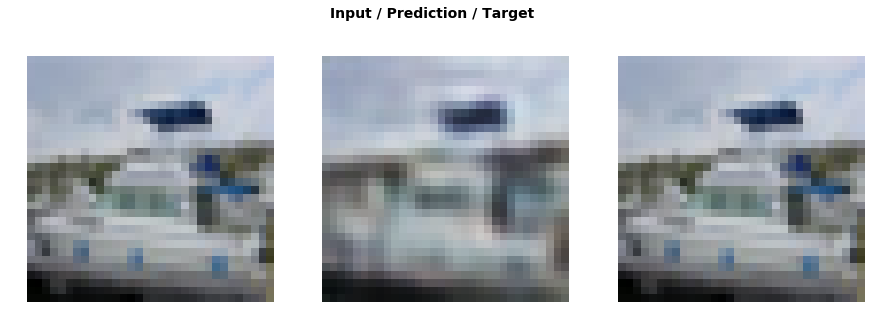

In [13]:
learn.show_results(rows=1, imgsize=5)

## Using the Encoder

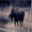

In [14]:
example = data.one_batch()[0]
Image(example[0])

In [15]:
example = data.one_batch(denorm = False)
inputs = example[0]

In [16]:
inputs.shape

torch.Size([32, 3, 32, 32])

In [17]:
encoded = autoencoder.encode(inputs)

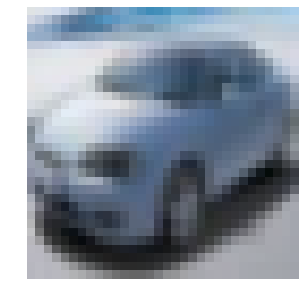

In [18]:
Image(example[1][0]).show(figsize = (5,5))

In [19]:
decoded = autoencoder.decoder(encoded)

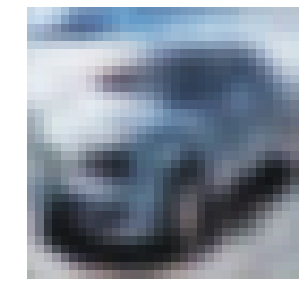

In [20]:
Image(decoded[0].detach()).show(figsize = (5,5))